# Least squares problems

We sometimes wish to solve problems of the form

$$
\boldsymbol{A} \boldsymbol{x} = \boldsymbol{b}
$$

where $\boldsymbol{A}$ is an $n \times m$ matrix where $m > n$. Clearly $\boldsymbol{A}$ is not square, and in general no solution to the problem exists. This is a typical of an over-determined problem - we have more equations than unknowns. A classical example is when trying to fit an $n$th-order polynomial to $k > n + 1$ data points - the degree of the polynomial is not high enough to construct an interpolating polynomial.

In this notebook we assume that $\boldsymbol{A}$ has full rank, i.e. the columns of $\boldsymbol{A}$ are linearly independent.

Before computing least-squares problems, we start with examples of polynomial interpolation.


## Polynomial interpolation

Polynomial interpolation involves fitting a $n$th order polynomial to $n+1$ data points. The polynomial interpolates each point.

### Interpolating the sine function

We first consider the interpolation of 20 equally spaces points that lie of the sine graph. To do this, we use NumPy to generate 20 points $\{ x_{i} \}$ on the interval $[-\pi, \pi]$, and evaluate $\sin(x)$ at each point such that $\boldsymbol{y} = \{ \sin(x_{i})\}$:

In [1]:
import numpy as np
N = 20
x_p = np.linspace(-np.pi, np.pi, N)
y_p = np.sin(x_p)

We use the variable `N` to hold the number of points so we can change it if we want to experiment.

We can plot the points:

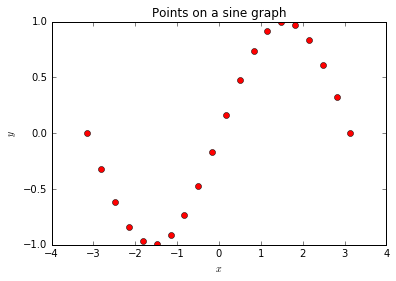

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Points on a sine graph')
plt.plot(x_p, y_p,'ro');

    With 20 data points, we can interpolate the points with a polynomial $f(x)$ of degree 19:

$$
f = c_{19} x^{19} + c_{18} x^{18} + \ldots  + c_{1} x + c_{0}.
$$

We can find the polynomial coefficients $c_{i}$ by solving  $\boldsymbol{A} \boldsymbol{c} = \boldsymbol{y}$, where $\boldsymbol{A}$ is the Vandermonde matrix:

$$ 
\boldsymbol{A} = \begin{bmatrix}
     x_{1}^{19} & x_{1}^{18} & \ldots & x_{1}^{2}  & x_{1} & 1  
    \\
     x_{2}^{19} & x_{2}^{18} & \ldots & x_{2}^{2}  & x_{2} & 1  
    \\
    \vdots  & \vdots & \vdots    & \ldots & \vdots   
    \\
     x_{20}^{19} & x_{20}^{18} & \ldots & x_{20}^{2}  & x_{20} & 1  
\end{bmatrix}
$$

the vector $\boldsymbol{c}$ contains the polynomial coefficient

$$ 
\boldsymbol{c} = \begin{bmatrix}
    c_{19} & c_{20} & \ldots & c_{0}  
\end{bmatrix}^{T}
$$

and the vector $\boldsymbol{y}$ contains the points $y_{i}$ that we wish to fit, which is this example are the points on the sine graph.

*Note: the ordering in each row of the Vandermonde matrix above is reversed with respect to what you will find in most books. We do this because earlier versions of NumPy built-in function for generating the Vandermonde matrix use the above ordering. Later verions provide an option to generate the more conventional ordering.*

Using the NumPy built-in function to generate the Vandermonde matrix:

In [3]:
A = np.vander(x_p, N)

We can solve the system to find the coefficients:

In [4]:
c = np.linalg.solve(A, y_p)

NumPy has a function `poly1d` to turn the coefficients into a polynomial object, and it can display a representation of the polynomial:

In [5]:
p = np.poly1d(c)
print(p)

            19             18             17             16
-7.442e-18 x  + 5.599e-20 x  + 2.798e-15 x  - 1.893e-18 x 
              15            14             13             12
 - 7.646e-13 x  + 2.55e-17 x  + 1.606e-10 x  - 1.746e-16 x 
              11             10             9            8
 - 2.505e-08 x  + 6.399e-16 x  + 2.756e-06 x - 1.19e-15 x
              7             6            5             4          3
 - 0.0001984 x + 8.638e-16 x + 0.008333 x + 1.468e-16 x - 0.1667 x
              2
 - 3.056e-16 x + 1 x


To plot the fitted polynomial, we evaluate the polynomial at 200 points:

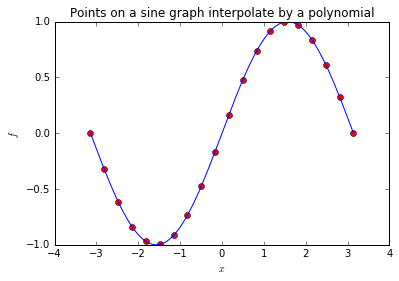

In [6]:
# Create an array of 200 equally spaced points on [-pi, pi]
x_fit = np.linspace(-np.pi, np.pi, 200) 

# Evaluate the polynomial at the points
y_fit = p(x_fit)

# Plot the interpolating polynomial and the sample points
plt.xlabel('$x$')
plt.ylabel('$f$')
plt.title('Points on a sine graph interpolate by a polynomial')
plot = plt.plot(x_p, y_p, 'ro', x_fit, y_fit,'b-');

We can see from the graph that the polynomial closely ressambles the sine function.

### Interpolating a noisy sine curve

We now repeat the fitting exercise, but we now add a small amount of noise to the points on the sine curve that we wish to interpolate: 

In [7]:
def y_p_noise(noise):
    return y_p + noise*(np.random.rand(len(y_p)) - 0.5)
y_p = y_p_noise(0.02)

We can plot the points:

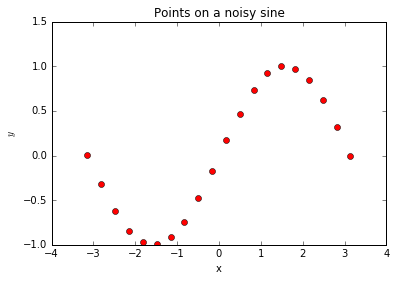

In [8]:
plt.xlabel('x')
plt.ylabel('$y$')
plt.title('Points on a noisy sine')
plt.plot(x_p, y_p, 'ro');

To the eye, the noise is hard to detect.

We can solve the system to find the coefficients:

In [9]:
c_noise = np.linalg.solve(A, y_p)

In [10]:
p_noise = np.poly1d(c_noise)

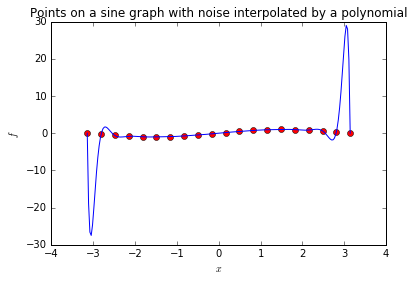

In [11]:
y_noise_fit = p_noise(x_fit)

plt.xlabel('$x$')
plt.ylabel('$f$')
plt.title('Points on a sine graph with noise interpolated by a polynomial')
plt.plot(x_p, y_p_noise(0.02), 'ro', x_fit, y_noise_fit,'b-');

The points are clearly interpolated, but the the result is now terrible near the boundaries of the interval, with large spikes.  The spikes are known as Runge's phenomenon. A similar effect with a Fourier  basis is known as Gibb's phenomenon.

This is a common problem with polynomial fitting. With the exact sine point, we were lucky. With well-chosen, non-uniform interpolation points it is possible to improve the interpolation of points.

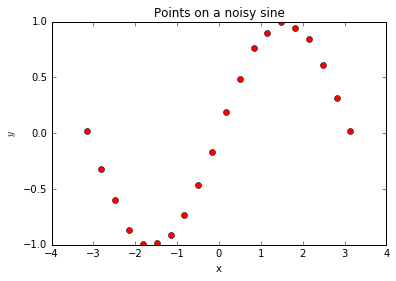

In [17]:
from ipywidgets import widgets
from ipywidgets import interact

@interact(noise=(0, 1, 0.02))
def plot_interp_sine(noise):
    y_p = y_p_noise(noise)
    c_noise = np.linalg.solve(A, y_p)
    p_noise = np.poly1d(c_noise)
    y_noise_fit = p_noise(x_fit)

    plt.xlabel('x')
    plt.ylabel('$y$')
    plt.title('Points on a noisy sine')
    plt.plot(x_p, y_p, 'ro');

### Conditioning of the Vandermonde matrix

We have seen by example already that the conditioning of the  Vandermonde matrix is poor. If the 
conditioning of  matrix $\boldsymbol{A}$ is poor, then the conditioning of the normal matrix $\boldsymbol{A}^{T}\boldsymbol{A}$ will be much worse:

The Vandermonde matrix is notoriously ill-conditioned. Computing the condition number:

In [ ]:
print("Condition number of the Vandermonde matrix: {}".format(np.linalg.cond(A, 2)))

We see the that the condition number is very large. Such a matrix should not be solved with methods such as LU decomposition (despite what is done in the above examples!).

## Least-squares fitting

We will now looking at fitting a polynomial of degree $k < n + 1$ to points on the sine graph. The degree of the polynomial is not high enough to interpolate all points, so we will compute a best-fit in the least-squares sense.

We have seen in lectures that solving the least squares solution involves solving 

$$
\boldsymbol{A}^{T}\boldsymbol{A} \boldsymbol{c} = \boldsymbol{A}^{T} \boldsymbol{y}
$$

If we want ot fit a $5$th-order polynomial to 20 data points, $\boldsymbol{A}$ is the $20 \times 6$ matrix:

$$ 
\boldsymbol{A} = \begin{bmatrix}
     x_{1}^{5} & x_{1}^{4} & \ldots & x_{1}^{2}  & x_{1} & 1  
    \\
     x_{2}^{5} & x_{2}^{4} & \ldots & x_{2}^{2}  & x_{2} & 1  
    \\
    \vdots  & \vdots & \vdots    & \ldots & \vdots   
    \\
    \vdots  & \vdots & \vdots    & \ldots & \vdots   
    \\
     x_{20}^{5} & x_{20}^{4} & \ldots & x_{20}^{2}  & x_{20} & 1  
\end{bmatrix}
$$

and $\boldsymbol{c}$ contains the $6$ polynomial coefficients 

$$ 
\boldsymbol{c} 
    = \begin{bmatrix}
     c_{0} & c_{1} & c_{2} & c_{3} & c_{4}
    \end{bmatrix}
$$

and $\boldsymbol{y}$ contains the 20 points we want to fit.

### Fitting points on the sine graph

Let's try fitting a lower-order polynomial to the 20 data points without noise. We start with a polynomial of degree 6. We first create the Vandermonde matrix:

In [18]:
A = np.vander(x_p, 6)

and then solve $$\boldsymbol{A}^{T}\boldsymbol{A} \boldsymbol{c} = \boldsymbol{A}^{T} \boldsymbol{y}$$ and create a NumPy polynomial from the coefficients:

In [19]:
ATA = (A.T).dot(A)
c_ls = np.linalg.solve(ATA, (A.T).dot(y_p))
p_ls = np.poly1d(c_ls)
print(p_ls)

          5            4         3             2
0.005366 x - 0.000106 x - 0.153 x + 0.0008867 x + 0.9856 x - 6.866e-05


Plotting the polynomial:

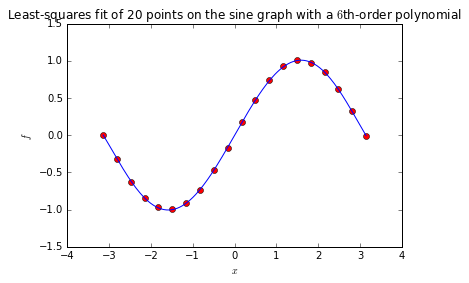

In [20]:
# Evaluate polynomial at some points
y_ls = p_ls(x_fit)

# Plot
plt.xlabel('$x$')
plt.ylabel('$f$')
plt.title('Least-squares fit of 20 points on the sine graph with a $6$th-order polynomial')
plt.plot(x_p, y_p, 'ro', x_fit, y_ls,'b-');

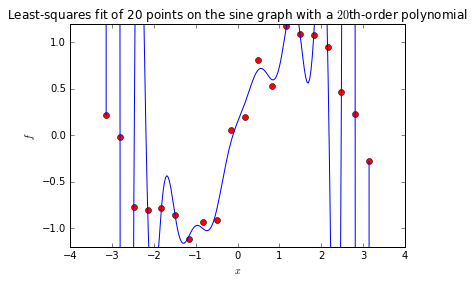

In [22]:
# Test
from ipywidgets import widgets
from ipywidgets import interact

@interact(order=(0, 20), noise=(0.0, 1.0, 0.001))
def plot(order, noise):

    # Create Vandermonde matrix    
    A = np.vander(x_p, order)
    
    y_p = y_p_noise(noise)
    
    ATA = (A.T).dot(A)
    c_ls = np.linalg.solve(ATA, (A.T).dot(y_p))
    p_ls = np.poly1d(c_ls)
    
    # Evaluate polynomial at some points
    y_ls = p_ls(x_fit)

    # Plot
    plt.xlabel('$x$')
    plt.ylabel('$f$')
    plt.ylim(-1.2, 1.2)
    plt.title('Least-squares fit of 20 points on the sine graph with a ${}$th-order polynomial'.format(order))
    plt.plot(x_p, y_p, 'ro', x_fit, y_ls,'b-');
    
#interact(plot, order=(0, 20), noise=(0.0, 1.0, 0.001))


The fit appears to be very good. We experiment now with some other order polynomials. We will use from now on the NumPy function `polyfit` to shorten the code. Moreover, `plolyfit` will uses a different solution algorithm from what we have above, namely a singular value decomposition, to compute the same problem but with less susceptibility to round-off errors.

Starting with degree 3:

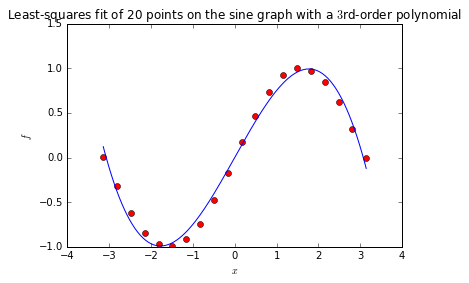

In [23]:
# Compute the coefficients of a 3rd order polynomial that fits the data points (x_p, y_p) 
c_ls = np.polyfit(x_p, y_p, 3)

# Create a polynomial object from the coefficients
p_ls = np.poly1d(c_ls)

# Evaluate the polynomial at the plotting points
y_ls = p_ls(x_fit)

# Plot
plt.xlabel('$x$')
plt.ylabel('$f$')
plt.title('Least-squares fit of 20 points on the sine graph with a $3$rd-order polynomial')
plt.plot(x_p, y_p, 'ro', x_fit, y_ls,'b-');

The fit is clearly not as good as for the $5$th order polynomial, nonetheless looks quite good. Now for a quadratic polynomial:

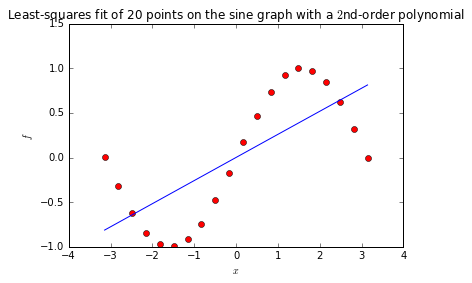

In [24]:
# Compute least squares fit
c_ls = np.polyfit(x_p, y_p, 2)
p_ls = np.poly1d(c_ls)
y_ls = p_ls(x_fit)

# Plot
plt.xlabel('$x$')
plt.ylabel('$f$')
plt.title('Least-squares fit of 20 points on the sine graph with a $2$nd-order polynomial')
plt.plot(x_p, y_p, 'ro', x_fit, y_ls,'b-');

Clearly the quadratic fit is very poor.

### Sine points with noise

Let's now look at a least-squares fit to the sine data with noise. We start by fitting a polynomial of degree 12:

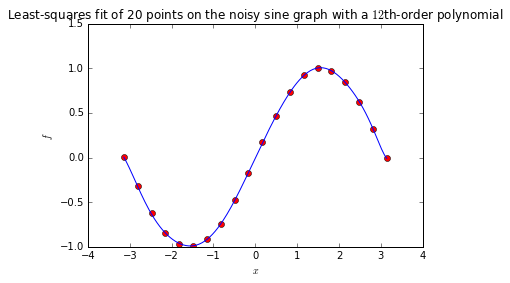

In [26]:
# Compute least squares fit
c_ls = np.polyfit(x_p, y_p_noise(0.02), 12)
p_ls = np.poly1d(c_ls)
y_ls = p_ls(x_fit)

# Plot
plt.xlabel('$x$')
plt.ylabel('$f$')
plt.title('Least-squares fit of 20 points on the noisy sine graph with a $12$th-order polynomial')
plt.plot(x_p, y_p, 'ro', x_fit, y_ls,'b-');

The fit looks very good, and note that there is no discernible noise at the ends of the interval.

**Exercise:** Experiment with increasing the polynomial order in the above least-squares problem 

### Conditioning of the normal matrix

We have seen already that the conditioning of the Vandermonde matrix $\boldsymbol{A}$ is poor. If we consider $\boldsymbol{A}^{T}\boldsymbol{A}$, we see that the conditioning is much worse again:

In [27]:
A = np.vander(x_p, 15)
print("Condition number of A (Vandermonde matrix, 15): {}".format(np.linalg.cond(A)))
print("Condition number of (A.T)A (Vandermonde matrix, 15): {}".format(np.linalg.cond((A.T).dot(A))))

Condition number of A (Vandermonde matrix, 15): 139063627.72223747
Condition number of (A.T)A (Vandermonde matrix, 15): 1.9335382952098824e+16


The poor condition number indicates why it is not a good idea to form and solve $\boldsymbol{A}^{T}\boldsymbol{A}$ directly. In practice, robust algorithms do not follow this approach.